In [1]:
import torch 
from torch import nn, Tensor
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [2]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

# Training

In [3]:
# Point cloud 생성
def generate_point_cloud(noise=0.02):
    
    P = Tensor(make_moons(n_samples=100, noise=0.05)[0])
    
    # Rotate in 2D plane randomly
    theta = torch.rand(1) * 2 * torch.pi
    R = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                      [torch.sin(theta), torch.cos(theta)]])
    
    # Translate randomly
    t = torch.rand(2) * 2 - 1
    
    # Apply transformation
    Q = (R @ P.T).T + t
    
    # Add Noise
    Q += torch.randn_like(Q) * noise
    
    # Make batch
    
    # P = P.unsqueeze(0)  # (1, N, 2)
    # Q = Q.unsqueeze(0)  # (1, N, 2)
    return P, Q
    

In [4]:
# Visualize point clouds
def visualize_point_clouds(P: Tensor, Q: Tensor, title: str, filename: str):
    plt.figure(figsize=(6, 6))
    plt.scatter(P[:, 0].cpu(), P[:, 1].cpu(), c='b', label='Source (P)')
    plt.scatter(Q[:, 0].cpu(), Q[:, 1].cpu(), c='r', label='Target (Q)')
    plt.title(title)
    plt.legend()
    plt.axis('equal')
    plt.savefig(filename)
    plt.close()


In [5]:
P, Q = generate_point_cloud()
visualize_point_clouds(P, Q, title='Initial Point Clouds', filename='initial_point_clouds.png')

In [6]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

pbar = tqdm(range(10000))
for _ in pbar:
    # x_1 = Tensor(make_moons(256, noise=0.15)[0])
    # x_0 = torch.randn_like(x_1)
    x_1, x_0 = generate_point_cloud(noise=0.1)
    
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss = loss_fn(flow(t=t, x_t=x_t), dx_t)
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f'Loss: {loss.item():.4f}')

Loss: 0.8703: 100%|██████████| 10000/10000 [00:20<00:00, 491.16it/s]


# Sampling

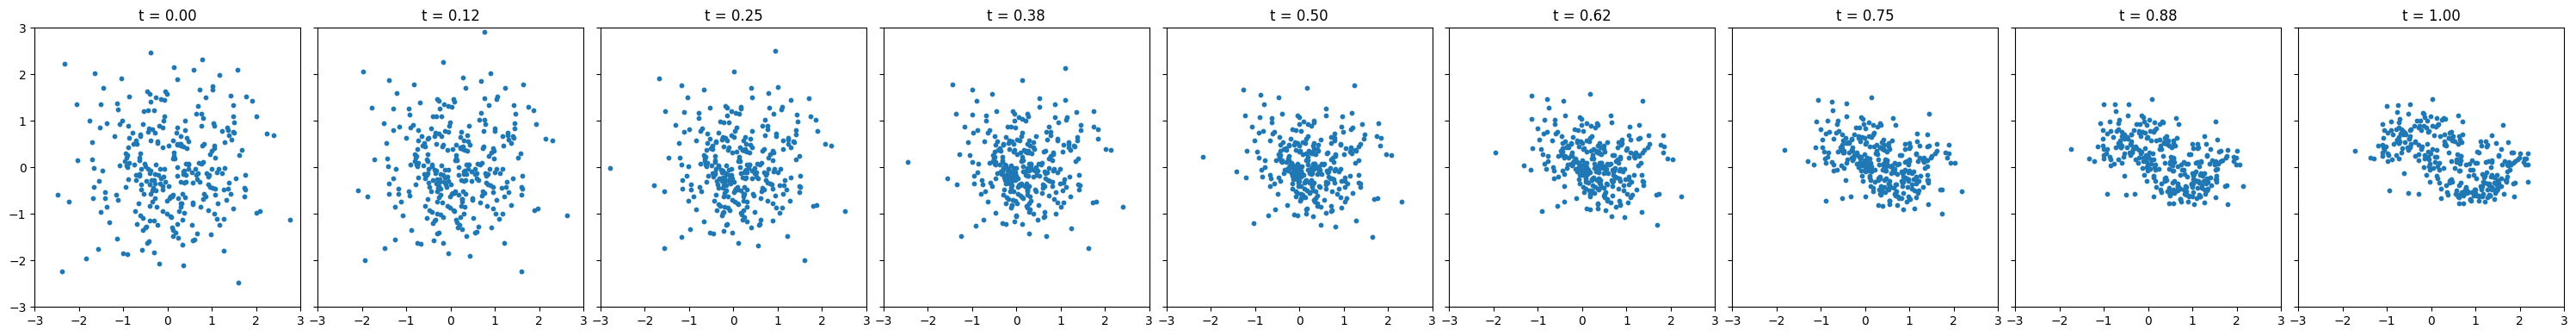

In [7]:
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

# Conditional Flow Matching
We now train a simple conditional model using class labels.

In [8]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [9]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, c_dim: int = 2, h: int = 64): # c_dim 추가
        super().__init__()
        
        # t(1) + c(c_dim) + x_t(dim)
        input_dim = 1 + c_dim + dim 
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, h), nn.ELU(), # input_dim 사용
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, c: Tensor, x_t: Tensor ) -> Tensor:
        return self.net(torch.cat((t, c, x_t), -1))
    
    # step 함수는 올바르게 구현하셨습니다.
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor, c: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        h = t_end - t_start
        
        # k1: t_start에서의 속도
        k1 = self(t=t_start, c=c, x_t=x_t)
        
        # k2: 중간 지점에서의 속도
        k2 = self(t=t_start + h / 2, 
                  c=c, 
                  x_t=x_t + k1 * h / 2)
        
        # k2를 사용하여 최종 업데이트
        return x_t + h * k2

# Training

In [10]:
# 1. 새 모델을 인스턴스화합니다.
# (dim=2, c_dim=2가 기본값이므로 그냥 호출해도 됩니다.)
flow = Flow(dim=2, c_dim=2) 

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

pbar = tqdm(range(10000))
for _ in pbar:
    # x_1이 타겟(원본), x_0가 소스(변환본)
    x_1, x_0 = generate_point_cloud(noise=0.1)
    
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    
    # *** 핵심 변경점 ***
    # flow에 x_1을 'c' (condition)로 전달합니다.
    predicted_dx_t = flow(t=t, x_t=x_t, c=x_1) 
    
    loss = loss_fn(predicted_dx_t, dx_t)
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f'Loss: {loss.item():.4f}')

Loss: 0.0498: 100%|██████████| 10000/10000 [00:22<00:00, 439.61it/s]


# Sampling

In [11]:
# 1. n_samples를 인자로 받고, c (레이블)를 반환하도록 수정
def generate_point_cloud(n_samples=100, noise=0.02):
    
    # c (레이블)도 함께 받습니다.
    P, c = make_moons(n_samples=n_samples, noise=0.05)
    P = Tensor(P)
    c = Tensor(c) # (n_samples,)
    
    # Rotate in 2D plane randomly
    theta = torch.rand(1) * 2 * torch.pi
    R = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                      [torch.sin(theta), torch.cos(theta)]])
    
    # Translate randomly
    t = torch.rand(2) * 2 - 1
    
    # Apply transformation
    Q = (R @ P.T).T + t
    
    # Add Noise
    Q += torch.randn_like(Q) * noise
    
    # P가 x_1 (타겟), Q가 x_0 (소스), c가 레이블입니다.
    return P, Q, c

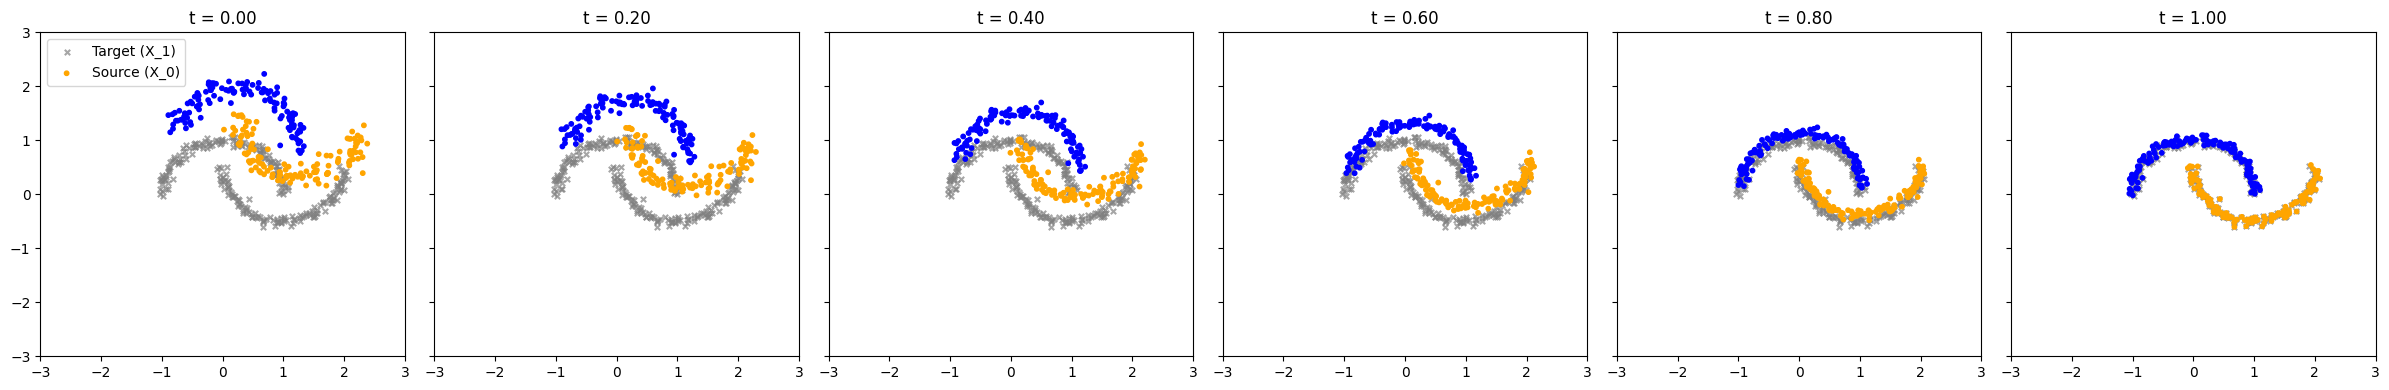

In [12]:
# --- evaluation / visualisation section (Correspondence Ver.) -----------------

# (위에 수정한 generate_point_cloud 함수가 정의되어 있다고 가정)
# (Flow 클래스와 학습된 'flow' 모델이 있다고 가정)

n_samples = 256 # 학습과 다른 개수도 가능

# 1. 테스트용 데이터 생성
# x_1_test (타겟), x_0_test (소스), c_labels (색상용)
x_1_test, x_0_test, c_labels = generate_point_cloud(n_samples=n_samples, noise=0.1)

# 2. 시작점(x)은 노이즈가 아닌 '소스' 포인트 클라우드 (x_0_test)입니다.
x = x_0_test.clone()  # .clone()으로 원본 유지

# 3. 조건(c_eval)은 (0,1)이 아닌 '타겟' 포인트 클라우드 (x_1_test)입니다.
c_eval = x_1_test 

# 4. 시각화를 위한 색상 (make_moons의 실제 레이블 기반)
colors = ['blue' if lbl == 0 else 'orange' for lbl in c_labels.tolist()]

# -----------------------------------------------------------------
n_steps      = 100
plot_every   = 20
plot_indices = list(range(0, n_steps + 1, plot_every))
if plot_indices[-1] != n_steps:
    plot_indices.append(n_steps)

fig, axes   = plt.subplots(1, len(plot_indices), figsize=(4 * len(plot_indices), 4),
                           sharex=True, sharey=True)
time_steps  = torch.linspace(0, 1.0, n_steps + 1)


# --- 모든 프레임에 걸쳐 플로팅 설정 ---
lims = (-3.0, 3.0)
for ax in axes:
    # 5. (핵심) 목표 지점(x_1_test)을 회색 'x'로 모든 축에 미리 그립니다.
    ax.scatter(x_1_test[:, 0], x_1_test[:, 1], s=15, c='gray', marker='x', alpha=0.7, label='Target (X_1)')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

# --- 초기 프레임 (t=0) ---
# 6. 시작 지점(x_0_test)을 색깔 있는 점으로 그립니다.
axes[0].scatter(x[:, 0], x[:, 1], s=10, c=colors, label='Source (X_0)')
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].legend()


plot_count = 0
with torch.no_grad():                         # no gradients while sampling
    for i in range(n_steps):
        # 7. flow.step에 현재 위치 x, 시간, 그리고 조건(c_eval = x_1_test)을 전달
        x = flow.step(x_t=x,
                      t_start=time_steps[i],
                      t_end=time_steps[i + 1],
                      c=c_eval) # c_eval은 x_1_test 입니다.
        
        # --- 중간 프레임 플로팅 ---
        if (i + 1) in plot_indices:
            plot_count += 1
            # 8. 이동 중인 포인트(x_t)를 그립니다.
            axes[plot_count].scatter(x[:, 0], x[:, 1], s=10, c=colors)
            axes[plot_count].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()